# **FAVOUR TAIWO ECX Assignment 2**

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !unzip "/content/drive/MyDrive/ECX/Assignment2/Building Types.zip"

## TENSORFLOW

### GETTING STARTED

In [ ]:
# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

### Define Constants

In [ ]:

IMAGE_HEIGHT = 400 # The height the image is to be resized to
IMAGE_WIDTH = 300 # The width the image is to be resized to
BATCH_SIZE = 8

# Define paths for data
data_dir = '/content/Building Types' # Ensure the name of the folder is set to this.
class_names = ['Bungalow', 'Highrise', 'Storey-Building']



### Implement Data Generators and Preprocessing pipeline

**This will create an easy preprocessing pipeline and will help load your data in batches**

In [ ]:
# Set up data generators for training and testing
datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize pixel values to [0,1]
    validation_split=0.3,      # 20% of data will be used for validation
)

train_generator = datagen.flow_from_directory(
    data_dir,                  # Path to your dataset
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'          # Use 70% of the data for training
)

temp_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)


print("Training class distribution:", train_generator.class_indices)
print("Validation class distribution:", temp_generator.class_indices)


Found 839 images belonging to 3 classes.
Found 358 images belonging to 3 classes.
Training class distribution: {'Bungalow': 0, 'High-rise': 1, 'Storey-building': 2}
Validation class distribution: {'Bungalow': 0, 'High-rise': 1, 'Storey-building': 2}


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Extract data and labels from the temporary generator
X_temp, y_temp = [], []
for i in range(len(temp_generator)):
    X, y = temp_generator[i]
    X_temp.append(X)
    y_temp.append(y)
    if i >= len(temp_generator) - 1:  # Avoid looping indefinitely
        break

X_temp = np.vstack(X_temp)
y_temp = np.vstack(y_temp)

# Split the temporary data into validation (20%) and test (10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.333,  # 10% test / 30% total = 0.333
    random_state=42
)

# Create validation and test generators
validation_generator = (X_val, y_val)
test_generator = (X_test, y_test)

In [ ]:
print(f"Validation data shape: {validation_generator[0].shape}")
print(f"Test data shape: {test_generator[0].shape}")

Validation data shape: (238, 400, 300, 3)
Test data shape: (120, 400, 300, 3)


### Model architecture

In [ ]:
# Define the model architecture UPDATED
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),  # Increased neurons
    tf.keras.layers.Dropout(0.5),  # Add dropout for regularization
    tf.keras.layers.Dense(3, activation='softmax')  # 3 classes for building types
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(3, activation='softmax')
# ])

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Adjust learning rate

In [ ]:
# Compile the model
model.compile(optimizer = optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy'])



In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.keras',  # Save the best model
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,  # Stop after 5 epochs without improvement
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,  # Reduce learning rate by a factor of 10
        patience=3,  # Wait for 3 epochs before reducing
        verbose=1
    )
]

### Train the model

In [ ]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data= validation_generator,  # Use the validation generator
    callbacks=callbacks
)
# This part of the code allows you to train the model. You can decide to tweak the number of epochs by experimenting with different values.
# Rule of thumb: Avoid using too large epochs, to avoid overfitting.

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4848 - loss: 1.6923
Epoch 1: val_loss improved from inf to 0.93059, saving model to best_model.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 315s 3s/step - accuracy: 0.4851 - loss: 1.6871 - val_accuracy: 0.5882 - val_loss: 0.9306 - learning_rate: 0.0010
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6530 - loss: 0.7372
Epoch 2: val_loss improved from 0.93059 to 0.87247, saving model to best_model.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 326s 3s/step - accuracy: 0.6529 - loss: 0.7373 - val_accuracy: 0.6303 - val_loss: 0.8725 - learning_rate: 0.0010
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7130 - loss: 0.6547
Epoch 3: val_loss did not improve from 0.87247
105/105 ━━━━━━━━━━━━━━━━━━━━ 309s 3s/step - accuracy: 0.7130 - loss: 0.6546 - val_accuracy: 0.6429 - val_loss: 1.0023 - learning_rate: 0.0010
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8449 - loss: 0.3789
Epoch 4: val_loss did not improv

### Evaluate the model

In [ ]:
test_loss, test_acc = model.evaluate(test_generator[0], test_generator[1], verbose=2)
print(f'Test accuracy: {test_acc*100:.2f}%')
print(f"Test Loss: {test_loss:.4f}")

4/4 - 8s - 2s/step - accuracy: 0.6500 - loss: 1.6294
Test accuracy: 65.00%
Test Loss: 1.6294


In [ ]:
from sklearn.metrics import classification_report

# Get predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Get true labels
y_true = np.argmax(test_generator[1], axis=1) # Get true labels from y_test

# Generate classification report
print(classification_report(y_true, y_pred_classes, target_names=class_names))

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=('Tensor(shape=(32, 400, 300, 3))', 'Tensor(shape=(32, 3))')
  warnings.warn(msg)


3/4 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=('Tensor(shape=(None, 400, 300, 3))', 'Tensor(shape=(None, 3))')
  warnings.warn(msg)


4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step
                 precision    recall  f1-score   support

       Bungalow       0.68      0.58      0.63        45
       Highrise       0.62      0.67      0.65        15
Storey-Building       0.64      0.70      0.67        60

       accuracy                           0.65       120
      macro avg       0.65      0.65      0.65       120
   weighted avg       0.65      0.65      0.65       120



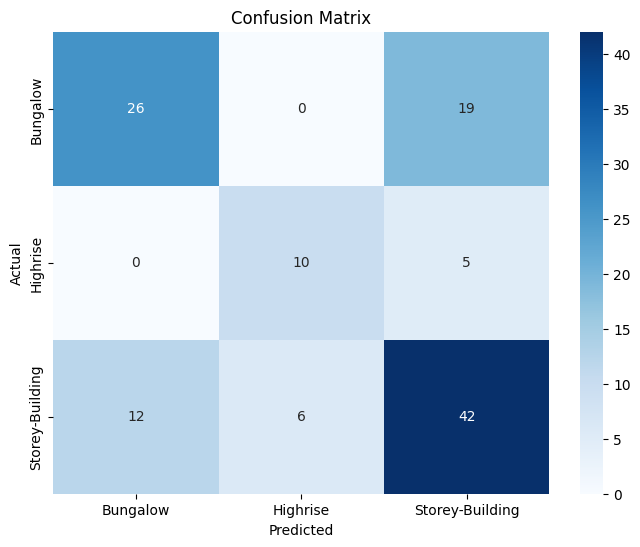

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### RESULT ANALYSIS

CASE 1:
      ImageDataGenerator twerked to carry out various edits
      Added More Convolutional Layers, **Accuracy is 58.40%**👀


CASE 2:
      BatchSize increase to 64
       **Accuracy is 58.40%** 👀    

CASE 3:
      Epoch increased to 20
       **Accuracy is 60.50%** 👀

CASE 4 :
      train test validation approach used
       **Accuracy is 65%** 👀

CASE 5:
      callbacks added
       **Accuracy is 59.17%** 👀

CASE 6:
      BatchNormalization
       **Accuracy is 37.50%** 👀

CASE 7:learnng rate 0.01 no normarlization
       **Accuracy is 50%** 👀
      

CASE 8:learnng rate 0.001, no normarlization and no edits to the image
       **Accuracy is 56.67%** 👀
      
CASE 9:learnng rate 0.001, no normarlization and no edits to the image, BatchSize=8
       **Accuracy is 65** 👀
      

### Save the Model

In [ ]:
path_to_save_model = '/content/Model_mi_Owon'

# Save the entire model (including architecture, weights, and optimizer state)
model.export(path_to_save_model)

# If you only want to save the model architecture and weights (without optimizer state)
# Uncomment the following line and comment out the previous 'model.save()' line
# model.save(path_to_save_model, save_format='tf')

Saved artifact at '/content/Model_mi_Owon'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 400, 300, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  135053844961168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135053844961360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135053755433424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135053755435536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135053755434768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135053755436112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135053844961552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135053755436496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135053755436880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135053755438416: TensorSpec(shape=(), dtype=tf.resource, name=None)


## PYTOUCH

In [ ]:
# Define paths for data
data_dir = '/content/Building Types' # Ensure the name of the folder is set to this.
class_names = ['Bungalow', 'Highrise', 'Storey-Building']

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import torch.nn.functional as F # Import F for functional operations

In [ ]:

# Hyperparameters
IMAGE_HEIGHT = 128  # Adjust based on your dataset
IMAGE_WIDTH = 128   # Adjust based on your dataset
BATCH_SIZE = 8      # Reduced batch size to avoid OOM
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
ACCUMULATION_STEPS = 4  # Gradient accumulation steps


In [ ]:

# Define transformations
transform = transforms.Compose([
    transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),  # Resize images
    transforms.ToTensor(),                          # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Load dataset
data_dir = "/content/Building Types"  # Replace with your dataset path
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Split dataset into train (70%), validation (20%), and test (10%)
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:

# Define the model
class BuildingClassifier(nn.Module):
    def __init__(self):
        super(BuildingClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)  # Fewer filters
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # Fewer filters
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Fewer filters
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * (IMAGE_HEIGHT // 8) * (IMAGE_WIDTH // 8), 128)  # Fewer neurons
        self.bn4 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 3)  # 3 output classes

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.bn4(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BuildingClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [ ]:

# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    optimizer.zero_grad()  # Reset gradients at the start of each epoch

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels) / ACCUMULATION_STEPS  # Scale loss
        loss.backward()  # Accumulate gradients

        # Update weights every `accumulation_steps` batches
        if (i + 1) % ACCUMULATION_STEPS == 0:
            optimizer.step()  # Update weights
            optimizer.zero_grad()  # Reset gradients

        # Compute statistics
        running_loss += loss.item() * ACCUMULATION_STEPS
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()


In [ ]:

    # Print training statistics
    train_loss = running_loss / len(train_loader)
    train_acc = 100.0 * correct / total
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100.0 * correct / total
    print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.2f}%")


Epoch [10/10], Train Loss: 0.2220, Train Acc: 92.83%
Validation Loss: 0.5803, Validation Acc: 75.31%


In [ ]:

# Evaluate on the test set
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


In [ ]:

# Classification report
class_names = list(dataset.class_to_idx.keys())
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
                 precision    recall  f1-score   support

       Bungalow       0.65      0.92      0.77        39
      High-rise       0.86      0.86      0.86        14
Storey-building       0.90      0.69      0.78        68

       accuracy                           0.79       121
      macro avg       0.81      0.82      0.80       121
   weighted avg       0.82      0.79      0.79       121



In [ ]:

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[36  0  3]
 [ 0 12  2]
 [19  2 47]]


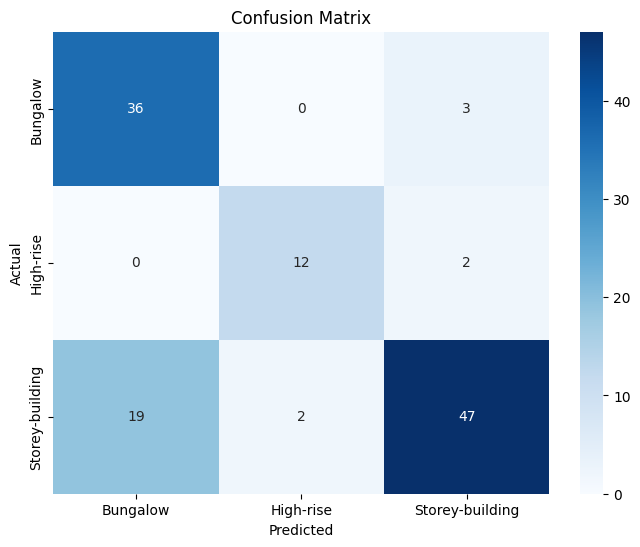

In [ ]:
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()